<a href="https://colab.research.google.com/github/Perrypenko/2025_nlp_w6_n-gram_GloVe/blob/main/problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from collections import Counter, defaultdict
!pip install koreanize_matplotlib
import koreanize_matplotlib

# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.3 MB/s eta 0:00:00


In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 폰트 설치 (Google Colab 환경인 경우)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# FontEntry를 사용하여 폰트 등록
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 폰트 파일 경로
    name='NanumGothic'  # 폰트 이름
)
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가

# 폰트 설정 적용
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126315 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

In [3]:
try:
    with open('corpus.txt', 'r', encoding='utf-8') as f:
        corpus = f.read()
except FileNotFoundError:
    # 샘플 말뭉치 생성
    corpus = """
    자연어 처리는 컴퓨터가 인간의 언어를 이해하고 처리하는 기술입니다.
    컴퓨터는 자연어 처리를 통해 텍스트를 분석하고 의미를 추출합니다.
    인공지능과 기계학습은 자연어 처리의 핵심 기술입니다.
    딥러닝 모델은 자연어 처리 성능을 크게 향상시켰습니다.
    워드 임베딩은 단어를 벡터 공간에 표현하는 방법입니다.
    GloVe와 Word2Vec은 대표적인 워드 임베딩 알고리즘입니다.
    언어 모델은 다음 단어를 예측하는 모델입니다.
    n-gram은 연속된 n개의 단어 시퀀스를 의미합니다.
    자연어 처리는 기계 번역, 감성 분석, 정보 추출 등에 활용됩니다.
    텍스트 전처리는 자연어 처리의 첫 단계입니다.
    """

    # 샘플 말뭉치 저장
    with open('corpus.txt', 'w', encoding='utf-8') as f:
        f.write(corpus)

print(f"말뭉치 크기: {len(corpus)} 문자")
print("\n샘플 텍스트:")
print(corpus[:300] + "...")

말뭉치 크기: 371 문자

샘플 텍스트:

    자연어 처리는 컴퓨터가 인간의 언어를 이해하고 처리하는 기술입니다.
    컴퓨터는 자연어 처리를 통해 텍스트를 분석하고 의미를 추출합니다.
    인공지능과 기계학습은 자연어 처리의 핵심 기술입니다.
    딥러닝 모델은 자연어 처리 성능을 크게 향상시켰습니다.
    워드 임베딩은 단어를 벡터 공간에 표현하는 방법입니다.
    GloVe와 Word2Vec은 대표적인 워드 임베딩 알고리즘입니다.
    언어 모델은 다음 단어를 예측하는 모델입니다.
    n-gram은 연속된 n개의 단어 시퀀스를 의미합니다.
    자...


In [4]:
def preprocess_text(text):
    # 줄바꿈 및 여러 공백 처리
    text = re.sub(r'\s+', ' ', text)

    # 문장 분리 (마침표, 물음표, 느낌표 기준)
    sentences = re.split(r'[.!?]\s', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # 각 문장에서 특수문자 제거 및 토큰화
    tokenized_sentences = []
    for sentence in sentences:
        # 특수문자 제거 (한글, 영문, 숫자, 공백만 유지)
        clean_sentence = re.sub(r'[^\w\s가-힣]', '', sentence)
        # 토큰화 (공백 기준)
        tokens = clean_sentence.split()
        tokenized_sentences.append(tokens)

    return tokenized_sentences

# 전처리 적용
tokenized_corpus = preprocess_text(corpus)

# 결과 확인
print(f"전처리된 문장 수: {len(tokenized_corpus)}")
for i, sentence in enumerate(tokenized_corpus[:3]):
    print(f"문장 {i+1}: {sentence}")

전처리된 문장 수: 10
문장 1: ['자연어', '처리는', '컴퓨터가', '인간의', '언어를', '이해하고', '처리하는', '기술입니다']
문장 2: ['컴퓨터는', '자연어', '처리를', '통해', '텍스트를', '분석하고', '의미를', '추출합니다']
문장 3: ['인공지능과', '기계학습은', '자연어', '처리의', '핵심', '기술입니다']


In [5]:
def build_vocabulary(tokenized_sentences):
    # 모든 단어 수집
    all_words = [word for sentence in tokenized_sentences for word in sentence]

    # 단어 빈도 계산
    word_counts = Counter(all_words)

    # 빈도순으로 정렬 (가장 빈번한 것부터)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # 단어에 ID 할당 (빈도순)
    word_to_id = {word: i for i, (word, _) in enumerate(sorted_words)}
    id_to_word = {i: word for word, i in word_to_id.items()}

    return word_to_id, id_to_word, word_counts

word_to_id, id_to_word, word_counts = build_vocabulary(tokenized_corpus)

# 어휘 사전 정보 출력
vocab_size = len(word_to_id)
print(f"어휘 사전 크기: {vocab_size} 단어")
print("\n가장 빈번한 단어 10개:")
for word, count in list(word_counts.most_common(10)):
    print(f"{word}: {count}회")

어휘 사전 크기: 59 단어

가장 빈번한 단어 10개:
자연어: 6회
처리는: 2회
기술입니다: 2회
처리의: 2회
모델은: 2회
워드: 2회
단어를: 2회
컴퓨터가: 1회
인간의: 1회
언어를: 1회


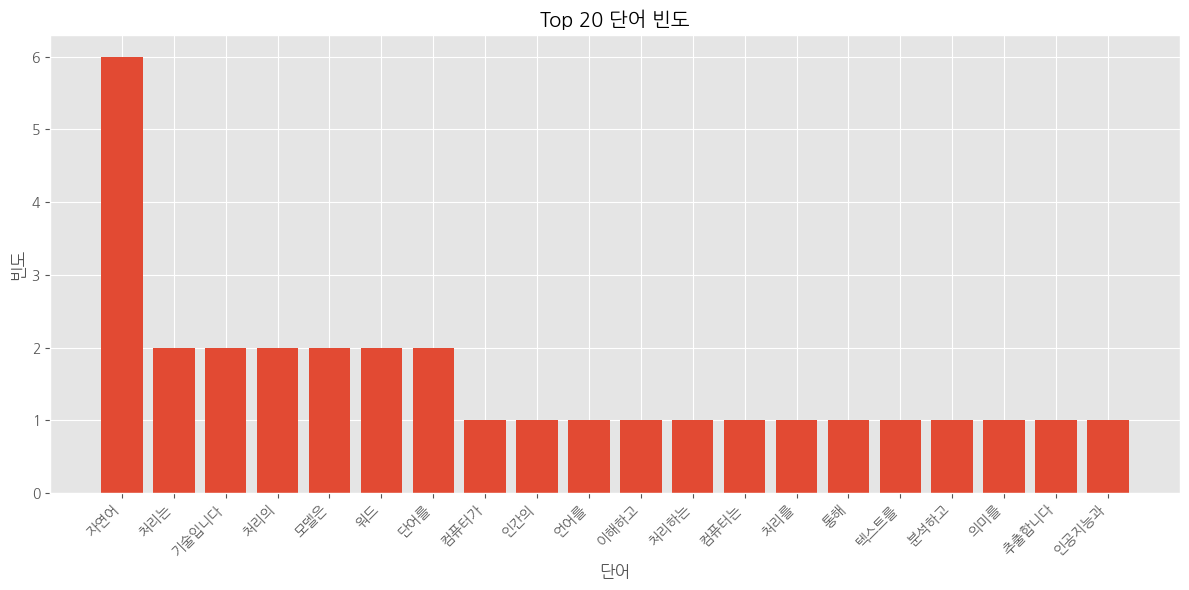

In [6]:
def plot_word_frequency(word_counts, top_n=20):
    most_common = word_counts.most_common(top_n)
    words, counts = zip(*most_common)

    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top {top_n} 단어 빈도')
    plt.xlabel('단어')
    plt.ylabel('빈도')
    plt.tight_layout()
    plt.show()

plot_word_frequency(word_counts)

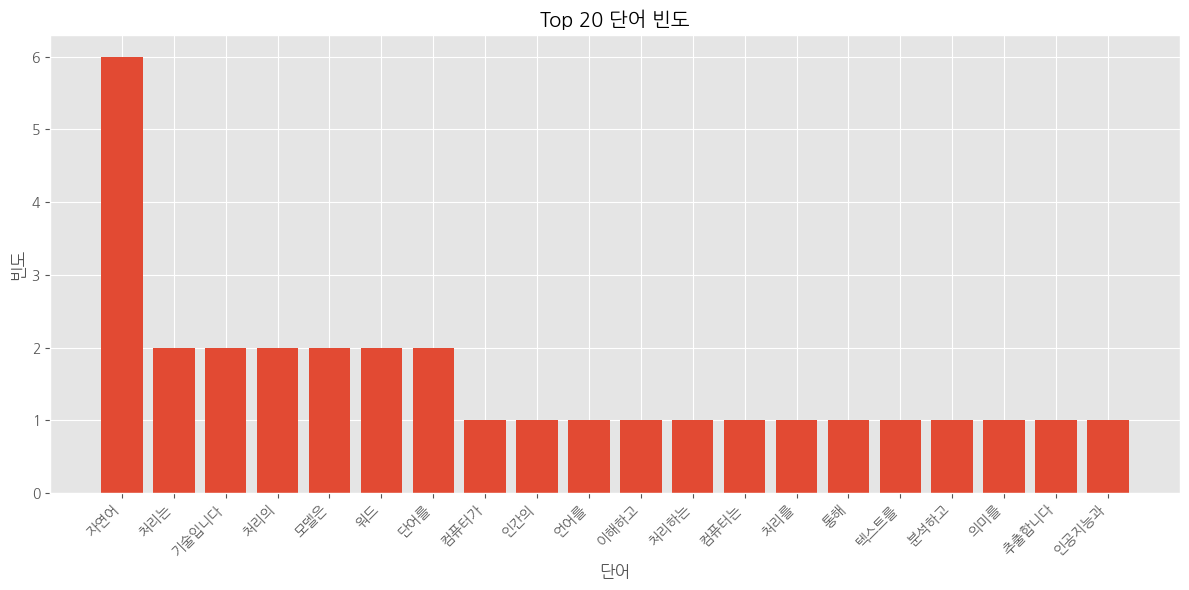

In [7]:
def plot_word_frequency(word_counts, top_n=20):
    most_common = word_counts.most_common(top_n)
    words, counts = zip(*most_common)

    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top {top_n} 단어 빈도')
    plt.xlabel('단어')
    plt.ylabel('빈도')
    plt.tight_layout()
    plt.show()

plot_word_frequency(word_counts)

In [8]:
import pickle

# 전처리 결과 저장
preprocessing_results = {
    'tokenized_corpus': tokenized_corpus,
    'word_to_id': word_to_id,
    'id_to_word': id_to_word,
    'word_counts': word_counts
}

with open('preprocessing_results.pkl', 'wb') as f:
    pickle.dump(preprocessing_results, f)

print("전처리 결과가 'preprocessing_results.pkl' 파일에 저장되었습니다.")

전처리 결과가 'preprocessing_results.pkl' 파일에 저장되었습니다.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict, Counter
import math

# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline

In [10]:
try:
    with open('preprocessing_results.pkl', 'rb') as f:
        preprocessing_results = pickle.load(f)

    tokenized_corpus = preprocessing_results['tokenized_corpus']
    word_to_id = preprocessing_results['word_to_id']
    id_to_word = preprocessing_results['id_to_word']
    word_counts = preprocessing_results['word_counts']

    print("전처리 결과를 성공적으로 불러왔습니다.")
    print(f"어휘 사전 크기: {len(word_to_id)} 단어")
    print(f"문장 수: {len(tokenized_corpus)}")
except FileNotFoundError:
    print("전처리 결과 파일을 찾을 수 없습니다. 먼저 '1_corpus_preprocessing.ipynb'를 실행해주세요.")

전처리 결과를 성공적으로 불러왔습니다.
어휘 사전 크기: 59 단어
문장 수: 10


In [11]:
def extract_ngrams(sentences, n=2):
    """문장들에서 n-gram을 추출하는 함수

    Args:
        sentences: 토큰화된 문장 목록
        n: n-gram의 n (기본값: 2, 즉 bigram)

    Returns:
        추출된 n-gram 목록
    """
    all_ngrams = []

    for sentence in sentences:
        # 문장의 길이가 n보다 작으면 n-gram을 추출할 수 없음
        if len(sentence) < n:
            continue

        # n-gram 추출
        sentence_ngrams = [tuple(sentence[i:i+n]) for i in range(len(sentence) - n + 1)]
        all_ngrams.extend(sentence_ngrams)

    return all_ngrams

# bigram (n=2) 추출 예시
bigrams = extract_ngrams(tokenized_corpus, n=2)
# trigram (n=3) 추출 예시
trigrams = extract_ngrams(tokenized_corpus, n=3)

print(f"추출된 bigram 수: {len(bigrams)}")
print(f"추출된 trigram 수: {len(trigrams)}")
print("\n샘플 bigram 5개:")
for bigram in bigrams[:5]:
    print(bigram)

추출된 bigram 수: 60
추출된 trigram 수: 50

샘플 bigram 5개:
('자연어', '처리는')
('처리는', '컴퓨터가')
('컴퓨터가', '인간의')
('인간의', '언어를')
('언어를', '이해하고')


In [12]:
print("\n샘플 trigram 5개:")
for trigram in trigrams[:5]:
    print(trigram)



샘플 trigram 5개:
('자연어', '처리는', '컴퓨터가')
('처리는', '컴퓨터가', '인간의')
('컴퓨터가', '인간의', '언어를')
('인간의', '언어를', '이해하고')
('언어를', '이해하고', '처리하는')


In [13]:
def build_cooccurrence_matrix(ngrams, vocab_size, word_to_id):
    """n-gram에서 동시출현 행렬을 구축하는 함수

    Args:
        ngrams: n-gram 목록
        vocab_size: 어휘 사전 크기
        word_to_id: 단어-ID 매핑 딕셔너리

    Returns:
        동시출현 행렬 (numpy array)
    """
    # 동시출현 행렬 초기화 (모든 원소가 0인 행렬)
    cooccurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    # n-gram에서 동시출현 빈도 계산
    for ngram in ngrams:
        # 첫 번째 단어는 행 인덱스, 두 번째 단어는 열 인덱스
        # bigram일 경우 (w_{i-1}, w_i)
        prev_word, curr_word = ngram[0], ngram[1]
        prev_id, curr_id = word_to_id[prev_word], word_to_id[curr_word]

        # 해당 단어 쌍의 동시출현 빈도 증가
        cooccurrence_matrix[prev_id, curr_id] += 1

    return cooccurrence_matrix

# bigram에 대한 동시출현 행렬 구축
vocab_size = len(word_to_id)
cooccurrence_matrix = build_cooccurrence_matrix(bigrams, vocab_size, word_to_id)

print(f"동시출현 행렬 크기: {cooccurrence_matrix.shape}")
print(f"총 동시출현 빈도: {cooccurrence_matrix.sum()}")
print(f"0이 아닌 원소 수: {np.count_nonzero(cooccurrence_matrix)}")

동시출현 행렬 크기: (59, 59)
총 동시출현 빈도: 60
0이 아닌 원소 수: 58


In [14]:
def calculate_conditional_probabilities(cooccurrence_matrix, vocab_size):
    """동시출현 행렬에서 조건부 확률 P(w_i | w_{i-1})을 계산하는 함수 (Laplace Smoothing 적용)

    Args:
        cooccurrence_matrix: 동시출현 행렬 (numpy array)
        vocab_size: 어휘 크기 V

    Returns:
        조건부 확률 행렬
    """
    # 기존: smoothing 없이 계산
    # 각 행의 합 계산 (각 단어 w_{i-1}의 출현 빈도)
    # row_sums = cooccurrence_matrix.sum(axis=1, keepdims=True)
    # 0으로 나누는 것을 방지하기 위해 0인 경우 1로 변경
    # row_sums[row_sums == 0] = 1
    # 조건부 확률 계산: P(w_i | w_{i-1}) = C(w_{i-1}, w_i) / C(w_{i-1})
    # conditional_probabilities = cooccurrence_matrix / row_sums

    # Laplace Smoothing 적용
    smoothed_matrix = cooccurrence_matrix + 1
    row_sums = smoothed_matrix.sum(axis=1, keepdims=True)  # 각 행 합 + V가 반영됨
    conditional_probabilities = smoothed_matrix / row_sums

    return conditional_probabilities


# 조건부 확률 계산
conditional_probabilities = calculate_conditional_probabilities(cooccurrence_matrix, vocab_size)

print(f"조건부 확률 행렬 크기: {conditional_probabilities.shape}")
# 0이 아닌 행(단어가 최소 한 번 이상 등장한 경우)의 합은 1이어야 함
non_zero_rows = cooccurrence_matrix.sum(axis=1) > 0
print(f"각 행의 합이 1인지 확인 (0이 아닌 행만): {np.allclose(conditional_probabilities[non_zero_rows].sum(axis=1), 1.0, rtol=1e-10)}")

조건부 확률 행렬 크기: (59, 59)
각 행의 합이 1인지 확인 (0이 아닌 행만): True


단어 '상위'를 어휘 사전에서 찾을 수 없습니다.


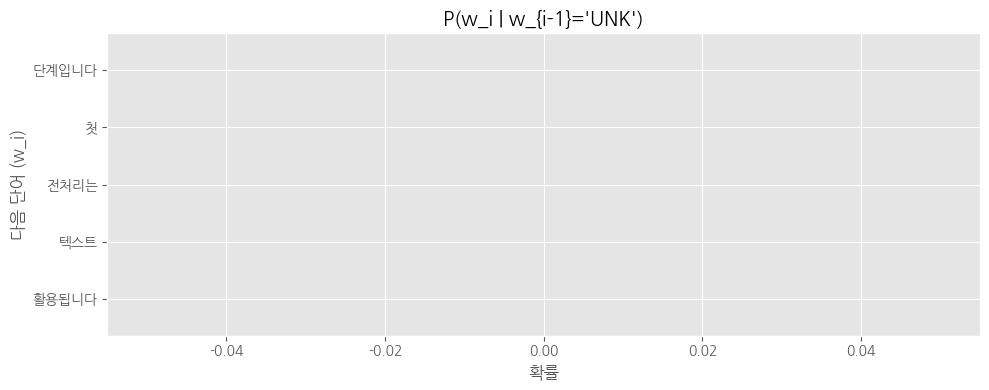

단어 '상위'를 어휘 사전에서 찾을 수 없습니다.

[로그 확률 출력: P(w_i | 상위)]
log(P(자연어 | 상위)) = -4.07753744390572
log(P(처리는 | 상위)) = -4.07753744390572
log(P(기술입니다 | 상위)) = -4.07753744390572
log(P(처리의 | 상위)) = -4.07753744390572
log(P(모델은 | 상위)) = -4.07753744390572
log(P(워드 | 상위)) = -4.07753744390572
log(P(단어를 | 상위)) = -4.07753744390572
log(P(컴퓨터가 | 상위)) = -4.07753744390572
log(P(인간의 | 상위)) = -4.07753744390572
log(P(언어를 | 상위)) = -4.07753744390572
log(P(이해하고 | 상위)) = -4.07753744390572
log(P(처리하는 | 상위)) = -4.07753744390572
log(P(컴퓨터는 | 상위)) = -4.07753744390572
log(P(처리를 | 상위)) = -4.07753744390572
log(P(통해 | 상위)) = -4.07753744390572
log(P(텍스트를 | 상위)) = -4.07753744390572
log(P(분석하고 | 상위)) = -4.07753744390572
log(P(의미를 | 상위)) = -4.07753744390572
log(P(추출합니다 | 상위)) = -4.07753744390572
log(P(인공지능과 | 상위)) = -4.07753744390572
log(P(기계학습은 | 상위)) = -4.07753744390572
log(P(핵심 | 상위)) = -4.07753744390572
log(P(딥러닝 | 상위)) = -4.07753744390572
log(P(처리 | 상위)) = -4.07753744390572
log(P(성능을 | 상위)) = -4.07753744390572
log(P(크게 | 상

In [15]:
def visualize_conditional_probabilities(conditional_probabilities, id_to_word, prev_words, top_n=5):
    """특정 단어들에 대한 조건부 확률을 시각화하는 함수

    Args:
        conditional_probabilities: 조건부 확률 행렬
        id_to_word: ID-단어 매핑 딕셔너리
        prev_words: 이전 단어 목록
        top_n: 상위 몇 개의 확률을 표시할지 결정
    """
    fig, axes = plt.subplots(len(prev_words), 1, figsize=(10, 4 * len(prev_words)))
    if len(prev_words) == 1:
        axes = [axes]

    for i, prev_word in enumerate(prev_words):
        # 이전 단어의 ID
        try:
            prev_id = word_to_id[prev_word]
        except KeyError:
            print(f"단어 '{prev_word}'를 어휘 사전에서 찾을 수 없습니다.")
            # continue
            prev_id = 999
            prev_word = "UNK"
        if( prev_id == 999):
            probs = np.zeros(shape=(len(word_to_id),))
        else:
            probs = conditional_probabilities[prev_id]
        # 해당 단어의 조건부 확률 행 추출
        # probs = conditional_probabilities[prev_id]

        # 확률이 높은 상위 top_n개 단어 선택
        top_indices = np.argsort(probs)[-top_n:][::-1]
        top_probs = probs[top_indices]
        top_words = [id_to_word[idx] for idx in top_indices]

        # 시각화
        axes[i].barh(top_words, top_probs)
        axes[i].set_title(f"P(w_i | w_{{i-1}}='{prev_word}')", fontsize=14)
        axes[i].set_xlabel('확률', fontsize=12)
        axes[i].set_ylabel('다음 단어 (w_i)', fontsize=12)
        axes[i].invert_yaxis()  # 확률이 높은 단어를 위쪽에 표시

    plt.tight_layout()
    plt.show()

# 특정 단어들에 대한 조건부 확률 시각화
# 가장 빈도가 높은 단어들 중 일부 선택
most_common_words = [word for word, _ in word_counts.most_common(5)]
# visualize_conditional_probabilities(conditional_probabilities, id_to_word, most_common_words)
most_common_words = ["상위"] # 학습에 사용되지 않은 단어로 대체
visualize_conditional_probabilities(conditional_probabilities, id_to_word, most_common_words)

# 결과를 pandas DataFrame으로 변환하여 테이블 형태로 확인
def display_conditional_probability_table(conditional_probabilities, word_to_id, id_to_word, prev_word, top_n=5):
    """특정 단어에 대한 조건부 확률을 테이블 형태로 표시하는 함수"""
    try:
        prev_id = word_to_id[prev_word]
    except KeyError:
        print(f"단어 '{prev_word}'를 어휘 사전에서 찾을 수 없습니다.")
        # return None
        prev_id = 999 # 대체 ID

    if( prev_id == 999):
        probs = np.ones(shape=(len(word_to_id),))  # 먼저 1로 채우고
        probs = probs / np.sum(probs)              # 그걸 정규화해서 확률 분포로 만듦
    else:
        probs = conditional_probabilities[prev_id]
    top_indices = np.argsort(probs)[-top_n:][::-1]
    top_probs = probs[top_indices]
    top_words = [id_to_word[idx] for idx in top_indices]

    # DataFrame 생성
    df = pd.DataFrame({
        'Next Word (w_i)': top_words,
        f'P(w_i | w_{{i-1}}=\'{prev_word}\')': top_probs
    })

    # log 확률 시도 (삽질 유도)
    print(f"\n[로그 확률 출력: P(w_i | {prev_word})]")
    for idx, prob in enumerate(probs):
        try:
            logp = np.log(prob)
        except:
            logp = float('-inf')
        print(f"log(P({id_to_word[idx]} | {prev_word})) = {logp}")

    return df

# 예시: 첫 번째 단어에 대한 조건부 확률 테이블
example_word = most_common_words[0]
cond_prob_table = display_conditional_probability_table(conditional_probabilities, word_to_id, id_to_word, example_word)
if cond_prob_table is not None:
    print(cond_prob_table.to_string(index=False))

In [16]:
def calculate_nll(sentence, conditional_probabilities, word_to_id):
    """주어진 문장에 대한 Negative Log Likelihood를 계산하는 함수

    Args:
        sentence: 토큰화된 문장
        conditional_probabilities: 조건부 확률 행렬
        word_to_id: 단어-ID 매핑 딕셔너리

    Returns:
        NLL 값
    """
    if len(sentence) < 2:
        return float('inf')  # 문장이 너무 짧으면 bigram을 추출할 수 없음

    nll = 0.0
    for i in range(1, len(sentence)):
        prev_word, curr_word = sentence[i-1], sentence[i]

        # 단어가 어휘 사전에 없는 경우 처리
        if prev_word not in word_to_id or curr_word not in word_to_id:
            nll += 10.0  # 큰 패널티 부여
            continue

        prev_id, curr_id = word_to_id[prev_word], word_to_id[curr_word]
        prob = conditional_probabilities[prev_id, curr_id]

        # 확률이 0인 경우 처리 (smoothing)
        if prob == 0:
            nll += 10.0  # 큰 패널티 부여
        else:
            nll += -np.log(prob)

    return nll

# 예시 문장들에 대한 NLL 계산
example_sentences = [
    tokenized_corpus[0],  # 실제 말뭉치에서 첫 번째 문장
    tokenized_corpus[0][::-1],  # 첫 번째 문장을 역순으로 배열 (이상한 문장)
    ['자연어', '처리', '기술'],  # 간단한 문장
    ['인공지능', '기술', '발전']  # 다른 간단한 문장
]

print("문장별 Negative Log Likelihood:")
for i, sentence in enumerate(example_sentences):
    nll = calculate_nll(sentence, conditional_probabilities, word_to_id)
    print(f"문장 {i+1}: {' '.join(sentence)}, NLL = {nll:.4f}")

문장별 Negative Log Likelihood:
문장 1: 자연어 처리는 컴퓨터가 인간의 언어를 이해하고 처리하는 기술입니다, NLL = 23.4995
문장 2: 기술입니다 처리하는 이해하고 언어를 인간의 컴퓨터가 처리는 자연어, NLL = 28.6601
문장 3: 자연어 처리 기술, NLL = 13.4812
문장 4: 인공지능 기술 발전, NLL = 20.0000


In [17]:
def predict_next_word(prev_word, conditional_probabilities, word_to_id, id_to_word, top_n=5):
    """주어진 단어 다음에 올 가능성이 높은 단어들을 예측하는 함수

    Args:
        prev_word: 이전 단어
        conditional_probabilities: 조건부 확률 행렬
        word_to_id: 단어-ID 매핑 딕셔너리
        id_to_word: ID-단어 매핑 딕셔너리
        top_n: 상위 몇 개의 예측을 반환할지 결정

    Returns:
        예측된 단어와 확률의 리스트
    """
    # 단어가 어휘 사전에 없는 경우 처리
    if prev_word not in word_to_id:
        print(f"단어 '{prev_word}'를 어휘 사전에서 찾을 수 없습니다.")
        return []

    prev_id = word_to_id[prev_word]
    probs = conditional_probabilities[prev_id]

    # 확률이 높은 상위 top_n개 단어 선택
    top_indices = np.argsort(probs)[-top_n:][::-1]

    # 예측 결과 생성
    predictions = []
    for idx in top_indices:
        if probs[idx] > 0:  # 확률이 0인 경우 제외
            predictions.append((id_to_word[idx], probs[idx]))

    return predictions

# 예시: 특정 단어 다음에 올 가능성이 높은 단어 예측
example_words = most_common_words[:2]  # 가장 빈번한 단어 2개
for word in example_words:
    predictions = predict_next_word(word, conditional_probabilities, word_to_id, id_to_word)
    print(f"\n'{word}' 다음에 올 가능성이 높은 단어:")
    for next_word, prob in predictions:
        print(f"  {next_word}: {prob:.4f}")

단어 '상위'를 어휘 사전에서 찾을 수 없습니다.

'상위' 다음에 올 가능성이 높은 단어:


In [18]:
# n-gram 모델 결과 저장
ngram_results = {
    'bigrams': bigrams,
    'trigrams': trigrams,
    'cooccurrence_matrix': cooccurrence_matrix,
    'conditional_probabilities': conditional_probabilities
}

with open('ngram_results.pkl', 'wb') as f:
    pickle.dump(ngram_results, f)

print("n-gram 모델 결과가 'ngram_results.pkl' 파일에 저장되었습니다.")

n-gram 모델 결과가 'ngram_results.pkl' 파일에 저장되었습니다.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import scipy.sparse as sparse
from collections import defaultdict, Counter
import seaborn as sns

# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
try:
    with open('preprocessing_results.pkl', 'rb') as f:
        preprocessing_results = pickle.load(f)

    tokenized_corpus = preprocessing_results['tokenized_corpus']
    word_to_id = preprocessing_results['word_to_id']
    id_to_word = preprocessing_results['id_to_word']
    word_counts = preprocessing_results['word_counts']

    print("전처리 결과를 성공적으로 불러왔습니다.")
    print(f"어휘 사전 크기: {len(word_to_id)} 단어")
    print(f"문장 수: {len(tokenized_corpus)}")
except FileNotFoundError:
    print("전처리 결과 파일을 찾을 수 없습니다. 먼저 '1_corpus_preprocessing.ipynb'를 실행해주세요.")

# n-gram 결과 불러오기 (옵션)
try:
    with open('ngram_results.pkl', 'rb') as f:
        ngram_results = pickle.load(f)

    bigrams = ngram_results['bigrams']
    print("n-gram 결과를 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print("n-gram 결과 파일을 찾을 수 없습니다. 필요한 경우 '2_ngram_model.ipynb'를 실행해주세요.")

전처리 결과를 성공적으로 불러왔습니다.
어휘 사전 크기: 59 단어
문장 수: 10
n-gram 결과를 성공적으로 불러왔습니다.


In [24]:
def build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size=2):
    """GloVe 모델을 위한 동시출현 행렬을 구축하는 함수

    Args:
        tokenized_corpus: 토큰화된 말뭉치
        word_to_id: 단어-ID 매핑 딕셔너리
        window_size: 중심 단어 좌우의 윈도우 크기

    Returns:
        희소 행렬 형태의 동시출현 행렬
    """
    vocab_size = len(word_to_id)
    cooccurrence_dict = defaultdict(float)

    # 모든 문장에 대해 반복
    for sentence in tokenized_corpus:
        # 문장의 길이
        sentence_length = len(sentence)

        # 문장의 각 위치에 대해 반복
        for i, center_word in enumerate(sentence):
            # 중심 단어가 어휘 사전에 없는 경우 건너뜀
            if center_word not in word_to_id:
                continue

            center_id = word_to_id[center_word]

            # 윈도우 내의 단어들에 대해 반복
            window_start = max(0, i - window_size)
            window_end = min(sentence_length, i + window_size + 1)

            for j in range(window_start, window_end):
                # 중심 단어 자신은 건너뜀
                if i == j:
                    continue

                context_word = sentence[j]

                # 문맥 단어가 어휘 사전에 없는 경우 건너뜀
                if context_word not in word_to_id:
                    continue

                context_id = word_to_id[context_word]

                # 거리에 따른 가중치 계산 (거리가 멀수록 낮은 가중치)
                distance = abs(j - i)
                weight = 1.0 / distance

                # 동시출현 빈도 증가 (가중치 적용)
                cooccurrence_dict[(center_id, context_id)] += weight

    # 희소 행렬 생성을 위한 데이터 준비
    row_indices = []
    col_indices = []
    data = []

    for (i, j), value in cooccurrence_dict.items():
        row_indices.append(i)
        col_indices.append(j)
        data.append(value)

    # CSR 형식의 희소 행렬 생성
    cooccurrence_matrix = sparse.csr_matrix((data, (row_indices, col_indices)),
                                            shape=(vocab_size, vocab_size))

    return cooccurrence_matrix

# GloVe 동시출현 행렬 구축
window_size = 2  # 윈도우 크기 설정
cooccurrence_matrix_glove = build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size)

print(f"GloVe 동시출현 행렬 크기: {cooccurrence_matrix_glove.shape}")
print(f"총 동시출현 빈도: {cooccurrence_matrix_glove.sum():.2f}")
print(f"0이 아닌 원소 수: {cooccurrence_matrix_glove.nnz}")
print(f"희소성 (sparsity): {(1 - cooccurrence_matrix_glove.nnz / (cooccurrence_matrix_glove.shape[0] * cooccurrence_matrix_glove.shape[1])) * 100:.2f}%")

GloVe 동시출현 행렬 크기: (59, 59)
총 동시출현 빈도: 170.00
0이 아닌 원소 수: 216
희소성 (sparsity): 93.79%


In [31]:
def linear_weight(distance, window_size):
    return max(0, (window_size - distance + 1) / window_size)

def exponential_weight(distance, base=0.5):
    return base ** (distance - 1)

def build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size=2, weight_func='inverse'):
    vocab_size = len(word_to_id)
    cooccurrence_dict = defaultdict(float)

    for sentence in tokenized_corpus:
        sentence_length = len(sentence)

        for i, center_word in enumerate(sentence):
            if center_word not in word_to_id:
                continue

            center_id = word_to_id[center_word]

            window_start = max(0, i - window_size)
            window_end = min(sentence_length, i + window_size + 1)

            for j in range(window_start, window_end):
                if i == j:
                    continue

                context_word = sentence[j]
                if context_word not in word_to_id:
                    continue

                context_id = word_to_id[context_word]

                distance = abs(j - i)
                if weight_func == 'inverse':
                    weight = 1.0 / distance
                elif weight_func == 'linear':
                    weight = linear_weight(distance, window_size)
                elif weight_func == 'exponential':
                    weight = exponential_weight(distance)
                else:
                    raise ValueError("Unknown weight function")

                cooccurrence_dict[(center_id, context_id)] += weight

    row_indices, col_indices, data = [], [], []
    for (i, j), value in cooccurrence_dict.items():
        row_indices.append(i)
        col_indices.append(j)
        data.append(value)

    cooccurrence_matrix = sparse.csr_matrix((data, (row_indices, col_indices)),
                                            shape=(vocab_size, vocab_size))

    return cooccurrence_matrix

# 다양한 가중치 함수에 대해 동시출현 행렬 구축 및 비교
weight_functions = ['inverse', 'linear', 'exponential']
window_size = 3
cooccurrence_matrices = {}

for func in weight_functions:
    cooccurrence_matrices[func] = build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size=window_size, weight_func=func)
    print(f"가중치 함수: {func}")
    print(f"  총 동시출현 빈도: {cooccurrence_matrices[func].sum():.2f}")
    print(f"  0이 아닌 원소 수: {cooccurrence_matrices[func].nnz}")
    print(f"  희소성 (sparsity): {(1 - cooccurrence_matrices[func].nnz / (cooccurrence_matrices[func].shape[0] * cooccurrence_matrices[func].shape[1])) * 100:.2f}%")
    print()

# 특정 단어쌍의 동시출현 빈도 비교
example_word_pair = ("자연어", "처리")
word1_id, word2_id = word_to_id[example_word_pair[0]], word_to_id[example_word_pair[1]]

print(f"'{example_word_pair[0]}'와 '{example_word_pair[1]}'의 동시출현 빈도:")
for func in weight_functions:
    freq = cooccurrence_matrices[func][word1_id, word2_id]
    print(f"  가중치 함수 {func}: {freq:.2f}")

가중치 함수: inverse
  총 동시출현 빈도: 196.67
  0이 아닌 원소 수: 296
  희소성 (sparsity): 91.50%

가중치 함수: linear
  총 동시출현 빈도: 213.33
  0이 아닌 원소 수: 296
  희소성 (sparsity): 91.50%

가중치 함수: exponential
  총 동시출현 빈도: 190.00
  0이 아닌 원소 수: 296
  희소성 (sparsity): 91.50%

'자연어'와 '처리'의 동시출현 빈도:
  가중치 함수 inverse: 1.00
  가중치 함수 linear: 1.00
  가중치 함수 exponential: 1.00


In [25]:
!pip install seaborn
!pip install koreanize_matplotlib
import seaborn as sns
import koreanize_matplotlib

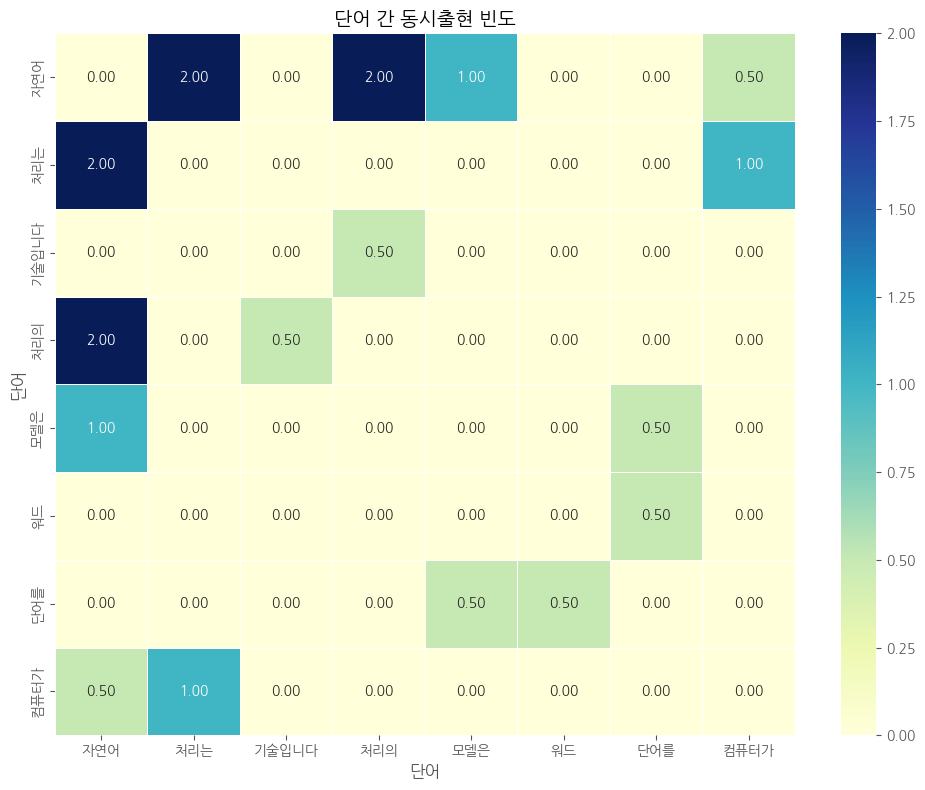

In [26]:
def visualize_cooccurrence_heatmap(cooccurrence_matrix, word_to_id, id_to_word, target_words, figsize=(10, 8)):
    """특정 단어들의 동시출현 패턴을 히트맵으로 시각화하는 함수

    Args:
        cooccurrence_matrix: 동시출현 행렬
        word_to_id: 단어-ID 매핑 딕셔너리
        id_to_word: ID-단어 매핑 딕셔너리
        target_words: 시각화할 단어 목록
        figsize: 그림 크기
    """
    # 대상 단어들의 ID 리스트
    target_ids = []
    for word in target_words:
        try:
            target_ids.append(word_to_id[word])
        except KeyError:
            print(f"단어 '{word}'를 어휘 사전에서 찾을 수 없습니다.")

    if not target_ids:
        print("시각화할 단어가 없습니다.")
        return

    # 대상 단어들만의 부분 행렬 추출
    sub_matrix = cooccurrence_matrix[target_ids, :][:, target_ids].toarray()

    # 히트맵 시각화
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(sub_matrix, annot=True, fmt=".2f", linewidths=0.5,
                xticklabels=[id_to_word[i] for i in target_ids],
                yticklabels=[id_to_word[i] for i in target_ids],
                cmap="YlGnBu", ax=ax)
    plt.title("단어 간 동시출현 빈도", fontsize=14)
    plt.xlabel("단어", fontsize=12)
    plt.ylabel("단어", fontsize=12)
    plt.tight_layout()
    plt.show()

# 특정 단어들의 동시출현 패턴 시각화
# 가장 빈번한 단어들 중 일부 선택
most_common_words = [word for word, _ in word_counts.most_common(10)]
most_common_words = [word for word, _ in word_counts.most_common(10)]
target_words = most_common_words[:8]  # 상위 8개 단어
visualize_cooccurrence_heatmap(cooccurrence_matrix_glove, word_to_id, id_to_word, target_words)


'자연어'와 가장 자주 동시출현하는 단어들:
  처리의: 2.00
  전처리는: 1.00
  처리: 1.00
  모델은: 1.00
  컴퓨터는: 1.00
  처리를: 1.00
  기계학습은: 1.00
  기계: 0.50
  첫: 0.50
  텍스트: 0.50


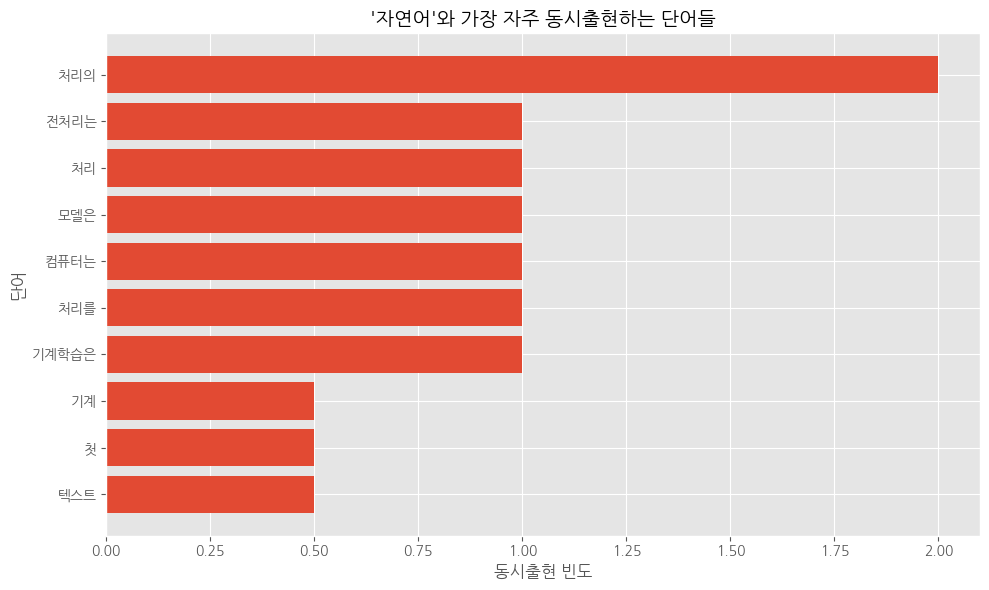


'처리는'와 가장 자주 동시출현하는 단어들:
  컴퓨터가: 1.00
  기계: 1.00
  번역: 0.50
  인간의: 0.50


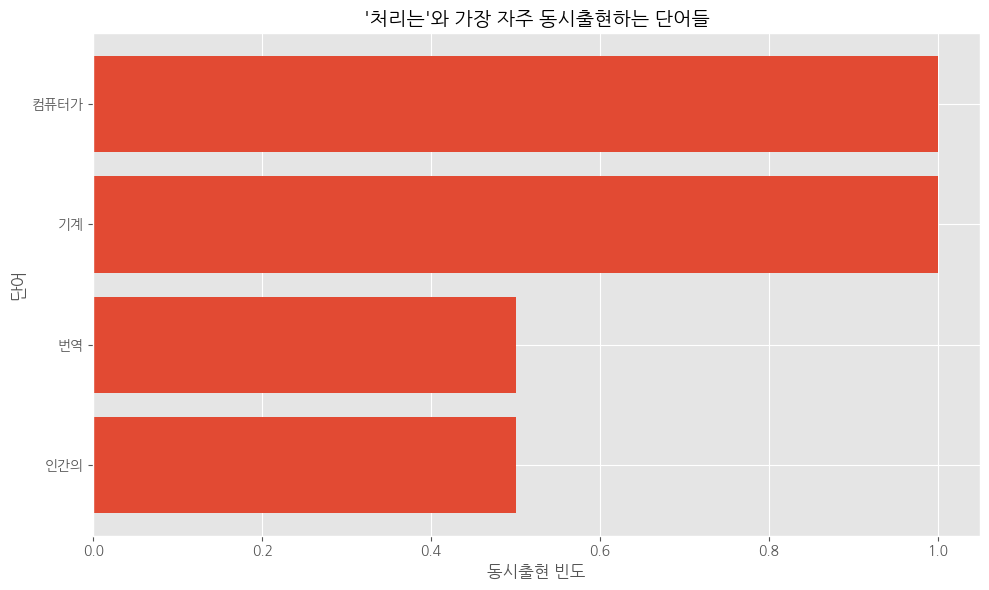


'기술입니다'와 가장 자주 동시출현하는 단어들:
  처리하는: 1.00
  이해하고: 0.50
  처리의: 0.50


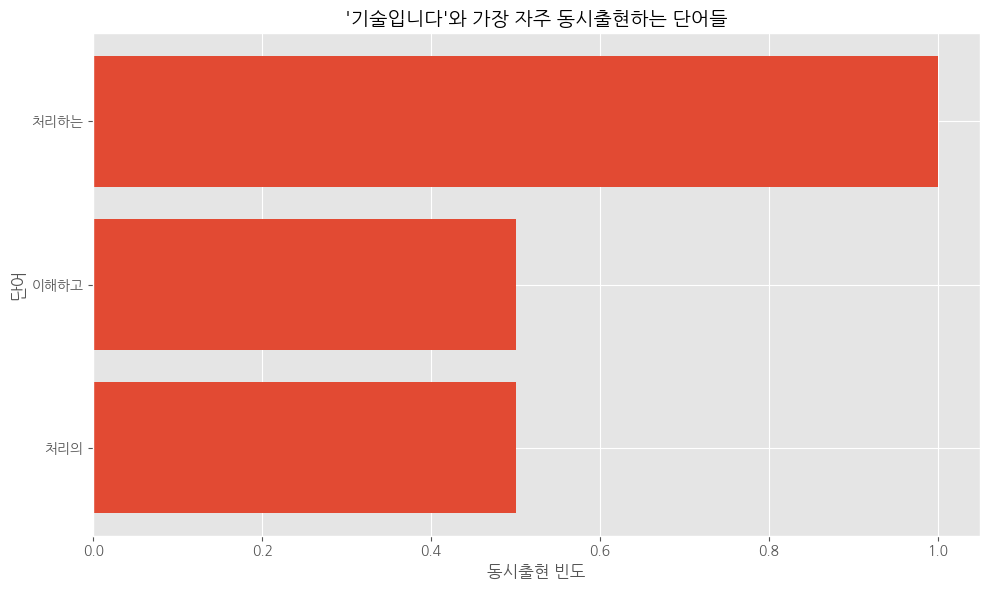

In [27]:
def find_top_cooccurring_words(word, cooccurrence_matrix, word_to_id, id_to_word, top_n=10):
    """특정 단어와 가장 자주 동시출현하는 단어들을 찾는 함수

    Args:
        word: 대상 단어
        cooccurrence_matrix: 동시출현 행렬
        word_to_id: 단어-ID 매핑 딕셔너리
        id_to_word: ID-단어 매핑 딕셔너리
        top_n: 상위 몇 개의 단어를 반환할지 결정

    Returns:
        상위 동시출현 단어와 빈도의 리스트
    """
    try:
        word_id = word_to_id[word]
    except KeyError:
        print(f"단어 '{word}'를 어휘 사전에서 찾을 수 없습니다.")
        return []

    # 해당 단어의 동시출현 벡터 추출
    cooccurrence_vec = cooccurrence_matrix[word_id].toarray().flatten()

    # 동시출현 빈도가 높은 상위 단어 인덱스 (자기 자신 제외)
    top_indices = np.argsort(cooccurrence_vec)[-top_n-1:-1][::-1]

    # 결과 생성
    result = []
    for idx in top_indices:
        if cooccurrence_vec[idx] > 0:  # 빈도가 0인 경우 제외
            result.append((id_to_word[idx], cooccurrence_vec[idx]))

    return result

def visualize_top_cooccurring_words(word, top_cooccurring, figsize=(10, 6)):
    """특정 단어와 가장 자주 동시출현하는 단어들을 막대 그래프로 시각화하는 함수"""
    if not top_cooccurring:
        return

    words, freqs = zip(*top_cooccurring)

    plt.figure(figsize=figsize)
    plt.barh(words, freqs)
    plt.title(f"'{word}'와 가장 자주 동시출현하는 단어들", fontsize=14)
    plt.xlabel('동시출현 빈도', fontsize=12)
    plt.ylabel('단어', fontsize=12)
    plt.gca().invert_yaxis()  # 빈도가 높은 단어를 위쪽에 표시
    plt.tight_layout()
    plt.show()

# 예시: 특정 단어들에 대한 동시출현 분석
example_words = most_common_words[:3]  # 상위 3개 단어
for word in example_words:
    top_cooccurring = find_top_cooccurring_words(word, cooccurrence_matrix_glove, word_to_id, id_to_word)
    print(f"\n'{word}'와 가장 자주 동시출현하는 단어들:")
    for cooccurring_word, freq in top_cooccurring:
        print(f"  {cooccurring_word}: {freq:.2f}")
    visualize_top_cooccurring_words(word, top_cooccurring)

동시출현 행렬 통계:
  총 동시출현 빈도: 170.00
  0이 아닌 원소 수: 216
  최대값: 2.00
  최소값 (0 제외): 0.50
  평균값 (0 제외): 0.79
  중앙값 (0 제외): 1.00


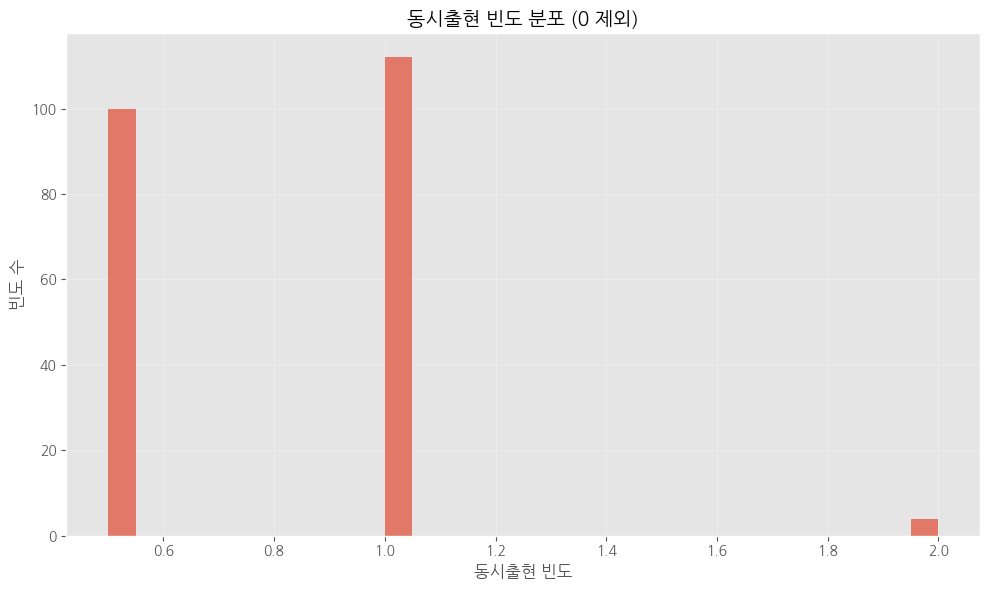

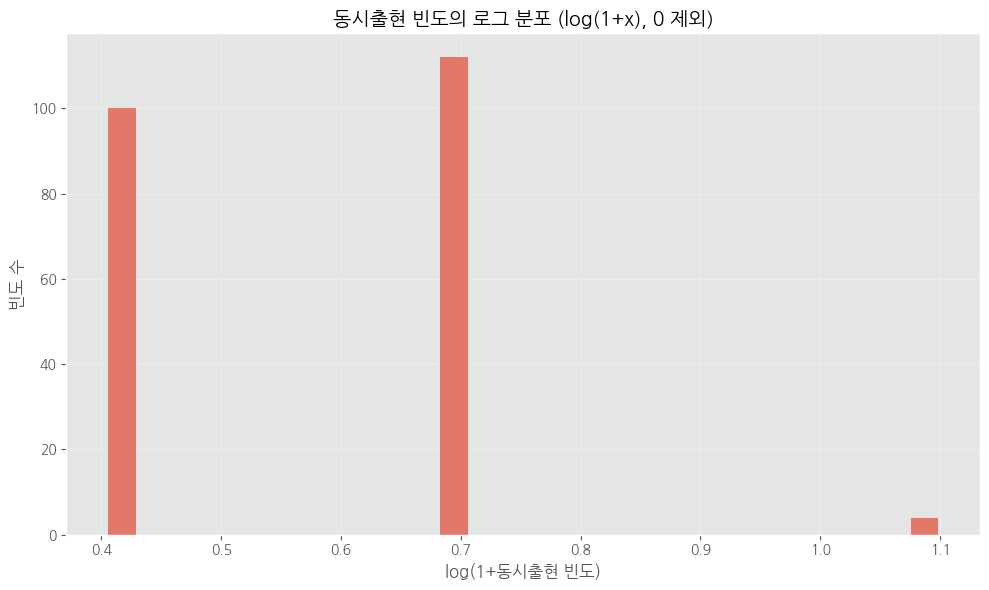

In [28]:
def analyze_cooccurrence_matrix(cooccurrence_matrix):
    """동시출현 행렬의 특성을 분석하는 함수

    Args:
        cooccurrence_matrix: 동시출현 행렬
    """
    # 행렬을 밀집 형태로 변환 (메모리 사용량 주의)
    dense_matrix = cooccurrence_matrix.toarray()

    # 기본 통계량
    non_zero_values = dense_matrix[dense_matrix > 0]

    print("동시출현 행렬 통계:")
    print(f"  총 동시출현 빈도: {cooccurrence_matrix.sum():.2f}")
    print(f"  0이 아닌 원소 수: {len(non_zero_values)}")
    print(f"  최대값: {non_zero_values.max():.2f}")
    print(f"  최소값 (0 제외): {non_zero_values.min():.2f}")
    print(f"  평균값 (0 제외): {non_zero_values.mean():.2f}")
    print(f"  중앙값 (0 제외): {np.median(non_zero_values):.2f}")

    # 동시출현 빈도 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(non_zero_values, bins=30, alpha=0.7)
    plt.title("동시출현 빈도 분포 (0 제외)", fontsize=14)
    plt.xlabel("동시출현 빈도", fontsize=12)
    plt.ylabel("빈도 수", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 로그 스케일 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(np.log1p(non_zero_values), bins=30, alpha=0.7)
    plt.title("동시출현 빈도의 로그 분포 (log(1+x), 0 제외)", fontsize=14)
    plt.xlabel("log(1+동시출현 빈도)", fontsize=12)
    plt.ylabel("빈도 수", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 동시출현 행렬 분석 (행렬 크기가 작을 때만 실행)
vocab_size = len(word_to_id)
if vocab_size <= 1000:  # 어휘 크기가 너무 크면 메모리 문제 발생 가능
    analyze_cooccurrence_matrix(cooccurrence_matrix_glove)
else:
    print(f"어휘 크기({vocab_size})가 너무 커서 동시출현 행렬 분석을 건너뜁니다.")

In [29]:
# 결과 저장
glove_matrix_results = {
    'cooccurrence_matrix': cooccurrence_matrix_glove,
    'window_size': window_size
}

with open('glove_matrix_results.pkl', 'wb') as f:
    pickle.dump(glove_matrix_results, f)

print("GloVe 동시출현 행렬 결과가 'glove_matrix_results.pkl' 파일에 저장되었습니다.")

GloVe 동시출현 행렬 결과가 'glove_matrix_results.pkl' 파일에 저장되었습니다.


In [30]:
 !pip install torch

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import scipy.sparse as sparse
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
try:
    with open('preprocessing_results.pkl', 'rb') as f:
        preprocessing_results = pickle.load(f)

    word_to_id = preprocessing_results['word_to_id']
    id_to_word = preprocessing_results['id_to_word']

    print("전처리 결과를 성공적으로 불러왔습니다.")
    print(f"어휘 사전 크기: {len(word_to_id)} 단어")
except FileNotFoundError:
    print("전처리 결과 파일을 찾을 수 없습니다. 먼저 '1_corpus_preprocessing.ipynb'를 실행해주세요.")

# GloVe 동시출현 행렬 불러오기
try:
    with open('glove_matrix_results.pkl', 'rb') as f:
        glove_matrix_results = pickle.load(f)

    cooccurrence_matrix = glove_matrix_results['cooccurrence_matrix']
    window_size = glove_matrix_results['window_size']

    print("GloVe 동시출현 행렬을 성공적으로 불러왔습니다.")
    print(f"행렬 크기: {cooccurrence_matrix.shape}")
    print(f"0이 아닌 원소 수: {cooccurrence_matrix.nnz}")
    print(f"윈도우 크기: {window_size}")
except FileNotFoundError:
    print("GloVe 동시출현 행렬 파일을 찾을 수 없습니다. 먼저 '3_glove_matrix.ipynb'를 실행해주세요.")

전처리 결과를 성공적으로 불러왔습니다.
어휘 사전 크기: 59 단어
GloVe 동시출현 행렬을 성공적으로 불러왔습니다.
행렬 크기: (59, 59)
0이 아닌 원소 수: 216
윈도우 크기: 2


In [ ]:
class GloVeModel(nn.Module):
    """GloVe 모델 구현

    Args:
        vocab_size: 어휘 사전 크기
        embedding_dim: 임베딩 차원
    """
    def __init__(self, vocab_size, embedding_dim):
        super(GloVeModel, self).__init__()

        # 중심 단어 임베딩 행렬
        self.center_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # 문맥 단어 임베딩 행렬
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # 중심 단어 편향
        self.center_biases = nn.Embedding(vocab_size, 1)
        # 문맥 단어 편향
        self.context_biases = nn.Embedding(vocab_size, 1)

        # 가중치 초기화
        self.init_weights()

    def init_weights(self):
        """가중치 초기화 함수"""
        # 모든 임베딩 행렬의 가중치를 -0.5 ~ 0.5 사이의 균등 분포로 초기화
        nn.init.uniform_(self.center_embeddings.weight, -0.5, 0.5)
        nn.init.uniform_(self.context_embeddings.weight, -0.5, 0.5)

        # 편향 항을 0으로 초기화
        nn.init.zeros_(self.center_biases.weight)
        nn.init.zeros_(self.context_biases.weight)

    def forward(self, center_word_idx, context_word_idx):
        """순전파 함수

        Args:
            center_word_idx: 중심 단어 인덱스
            context_word_idx: 문맥 단어 인덱스

        Returns:
            예측값 (중심 벡터와 문맥 벡터의 내적 + 편향)
        """
        # 임베딩 가져오기
        center_embeds = self.center_embeddings(center_word_idx)  # [batch_size, embedding_dim]
        context_embeds = self.context_embeddings(context_word_idx)  # [batch_size, embedding_dim]
        center_biases = self.center_biases(center_word_idx).squeeze()  # [batch_size]
        context_biases = self.context_biases(context_word_idx).squeeze()  # [batch_size]

        # 예측값 계산
        dot_product = torch.sum(center_embeds * context_embeds, dim=1)  # [batch_size]
        log_cooccurrence = dot_product + center_biases + context_biases  # [batch_size]

        return log_cooccurrence

    def get_center_embeddings(self):
        """학습된 중심 단어 임베딩 반환"""
        return self.center_embeddings.weight.detach().cpu().numpy()

    def get_context_embeddings(self):
        """학습된 문맥 단어 임베딩 반환"""
        return self.context_embeddings.weight.detach().cpu().numpy()

    def get_combined_embeddings(self):
        """중심 단어 임베딩과 문맥 단어 임베딩의 평균 반환"""
        center = self.center_embeddings.weight.detach().cpu().numpy()
        context = self.context_embeddings.weight.detach().cpu().numpy()
        return (center + context) / 2.0

In [ ]:
!pip install koreanize_matplotlib
import koreanize_matplotlib

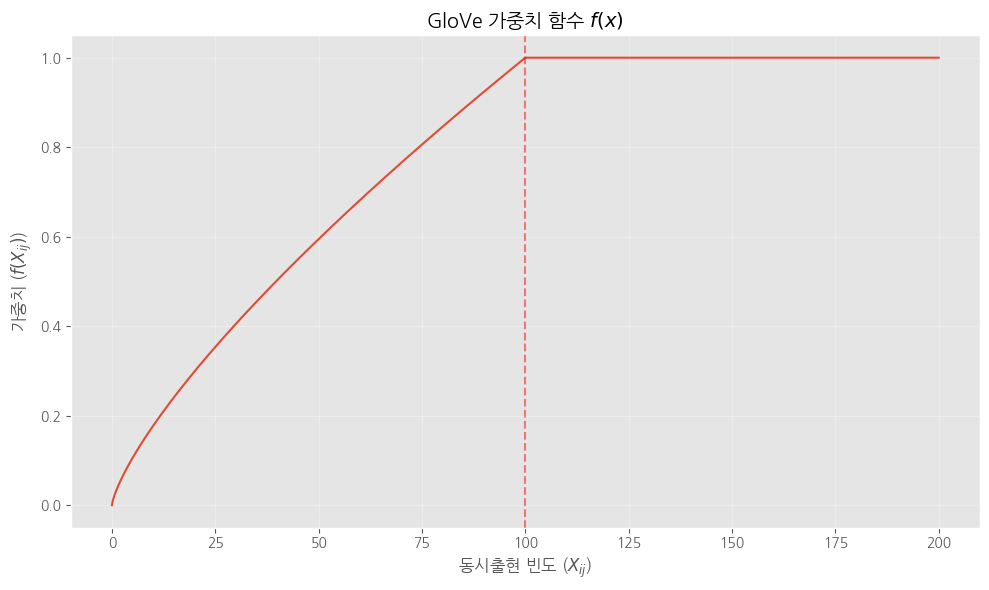

In [ ]:
def weight_func(x, x_max=100.0, alpha=0.75):
    """GloVe에서 사용하는 가중치 함수

    Args:
        x: 동시출현 빈도
        x_max: 최대 동시출현 빈도 기준값
        alpha: 가중치 함수의 지수 (보통 0.75)

    Returns:
        가중치 값
    """
    x = torch.clamp(x, min=0)  # 음수 방지
    return torch.minimum(torch.pow(x / x_max, alpha), torch.ones_like(x))

# 가중치 함수 시각화
x = np.linspace(0, 200, 1000)
weights = weight_func(torch.tensor(x)).numpy()

plt.figure(figsize=(10, 6))
plt.plot(x, weights)
plt.axvline(x=100, color='r', linestyle='--', alpha=0.5)
plt.title('GloVe 가중치 함수 $f(x)$', fontsize=14)
plt.xlabel('동시출현 빈도 ($X_{ij}$)', fontsize=12)
plt.ylabel('가중치 ($f(X_{ij})$)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
class GloVeDataset(Dataset):
    """GloVe 학습을 위한 데이터셋

    동시출현 행렬에서 비영(non-zero) 원소를 추출하여 데이터셋 구성

    Args:
        cooccurrence_matrix: 희소 행렬 형태의 동시출현 행렬
        device: 텐서를 저장할 장치 (CPU 또는 GPU)
    """
    def __init__(self, cooccurrence_matrix, device='cpu'):
        self.device = device

        # 희소 행렬에서 비영(non-zero) 원소 추출
        self.i_indices, self.j_indices = cooccurrence_matrix.nonzero()
        self.values = cooccurrence_matrix.data

        print(f"데이터셋 크기: {len(self.values)}")

    def __len__(self):
        return len(self.values)

    def __getitem__(self, idx):
        center_word_idx = self.i_indices[idx]
        context_word_idx = self.j_indices[idx]
        cooccurrence = self.values[idx]

        # 텐서로 변환
        center_word_idx = torch.tensor(center_word_idx, dtype=torch.long).to(self.device)
        context_word_idx = torch.tensor(context_word_idx, dtype=torch.long).to(self.device)
        cooccurrence = torch.tensor(cooccurrence, dtype=torch.float).to(self.device)
        log_cooccurrence = torch.log(cooccurrence + 1e-8)  # 수치 안정성을 위해 작은 값 추가

        return center_word_idx, context_word_idx, cooccurrence, log_cooccurrence

# GloVe 데이터셋 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = GloVeDataset(cooccurrence_matrix, device=device)

# 데이터 로더 생성
batch_size = 1024
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

데이터셋 크기: 216


In [ ]:
def glove_loss(predicted, log_cooccurrence, cooccurrence, x_max=100.0, alpha=0.75):
    """GloVe 손실 함수

    Args:
        predicted: 모델의 예측값 (w_i^T w_j + b_i + b_j)
        log_cooccurrence: 실제 동시출현 빈도의 로그값 (log X_ij)
        cooccurrence: 실제 동시출현 빈도 (X_ij)
        x_max: 최대 동시출현 빈도 기준값
        alpha: 가중치 함수의 지수

    Returns:
        손실 값
    """
    # 가중치 계산
    weights = weight_func(cooccurrence, x_max, alpha)

    # 손실 계산: f(X_ij) * (w_i^T w_j + b_i + b_j - log X_ij)^2
    squared_diff = torch.pow(predicted - log_cooccurrence, 2)
    weighted_squared_diff = weights * squared_diff

    return torch.mean(weighted_squared_diff)

In [ ]:
# 하이퍼파라미터 설정
vocab_size = len(word_to_id)
embedding_dim = 50  # 임베딩 차원
learning_rate = 0.05  # 학습률
num_epochs = 30  # 학습 에폭 수
x_max = 100.0  # 최대 동시출현 빈도 기준값
alpha = 0.75  # 가중치 함수의 지수

# 모델 초기화
model = GloVeModel(vocab_size, embedding_dim).to(device)

# 옵티마이저 설정
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

# 손실 기록을 위한 리스트
losses = []

# 학습 시작 시간 기록
start_time = time.time()

# 학습 루프
for epoch in range(num_epochs):
    epoch_loss = 0.0
    batch_count = 0

    for center_word_idx, context_word_idx, cooccurrence, log_cooccurrence in data_loader:
        # 순전파
        predicted = model(center_word_idx, context_word_idx)

        # 손실 계산
        loss = glove_loss(predicted, log_cooccurrence, cooccurrence, x_max, alpha)

        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실 누적
        epoch_loss += loss.item()
        batch_count += 1

    # 에폭당 평균 손실 계산
    avg_epoch_loss = epoch_loss / batch_count
    losses.append(avg_epoch_loss)

    # 학습 진행 상황 출력
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.6f}, Time: {elapsed_time:.2f}s")

# 학습 소요 시간 출력
total_time = time.time() - start_time
print(f"\n학습 완료: 총 {num_epochs} 에폭, 소요 시간: {total_time:.2f}초")

Epoch 1/30, Loss: 0.014924, Time: 0.09s
Epoch 2/30, Loss: 0.003012, Time: 0.13s
Epoch 3/30, Loss: 0.001128, Time: 0.15s
Epoch 4/30, Loss: 0.000506, Time: 0.17s
Epoch 5/30, Loss: 0.000256, Time: 0.19s
Epoch 6/30, Loss: 0.000163, Time: 0.21s
Epoch 7/30, Loss: 0.000115, Time: 0.23s
Epoch 8/30, Loss: 0.000078, Time: 0.26s
Epoch 9/30, Loss: 0.000053, Time: 0.28s
Epoch 10/30, Loss: 0.000038, Time: 0.30s
Epoch 11/30, Loss: 0.000027, Time: 0.32s
Epoch 12/30, Loss: 0.000019, Time: 0.36s
Epoch 13/30, Loss: 0.000013, Time: 0.39s
Epoch 14/30, Loss: 0.000009, Time: 0.42s
Epoch 15/30, Loss: 0.000006, Time: 0.49s
Epoch 16/30, Loss: 0.000004, Time: 0.53s
Epoch 17/30, Loss: 0.000003, Time: 0.59s
Epoch 18/30, Loss: 0.000002, Time: 0.63s
Epoch 19/30, Loss: 0.000002, Time: 0.65s
Epoch 20/30, Loss: 0.000001, Time: 0.66s
Epoch 21/30, Loss: 0.000001, Time: 0.69s
Epoch 22/30, Loss: 0.000001, Time: 0.72s
Epoch 23/30, Loss: 0.000001, Time: 0.75s
Epoch 24/30, Loss: 0.000000, Time: 0.79s
Epoch 25/30, Loss: 0.0000

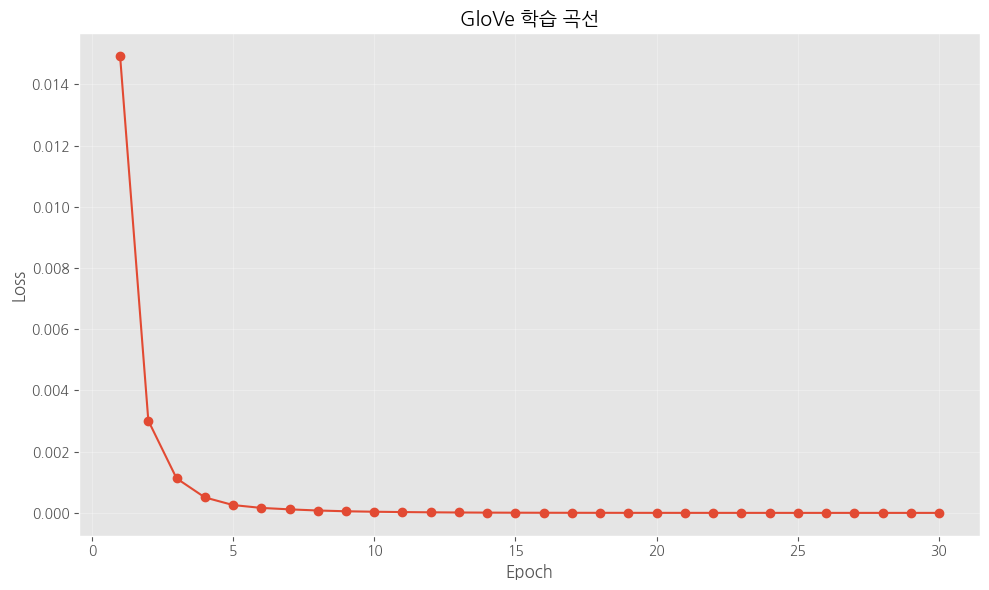

In [ ]:
# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.title('GloVe 학습 곡선', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# 학습된 임베딩 가져오기
center_embeddings = model.get_center_embeddings()
context_embeddings = model.get_context_embeddings()
combined_embeddings = model.get_combined_embeddings()

# 임베딩 저장
embeddings_results = {
    'center_embeddings': center_embeddings,
    'context_embeddings': context_embeddings,
    'combined_embeddings': combined_embeddings,
    'word_to_id': word_to_id,
    'id_to_word': id_to_word,
    'embedding_dim': embedding_dim,
    'losses': losses
}

with open('glove_embeddings_results.pkl', 'wb') as f:
    pickle.dump(embeddings_results, f)

print("GloVe 임베딩 결과가 'glove_embeddings_results.pkl' 파일에 저장되었습니다.")

GloVe 임베딩 결과가 'glove_embeddings_results.pkl' 파일에 저장되었습니다.


임베딩 행렬 크기: (59, 50)
임베딩 평균: -0.000427
임베딩 표준편차: 0.203122
임베딩 최소값: -0.536415
임베딩 최대값: 0.555454


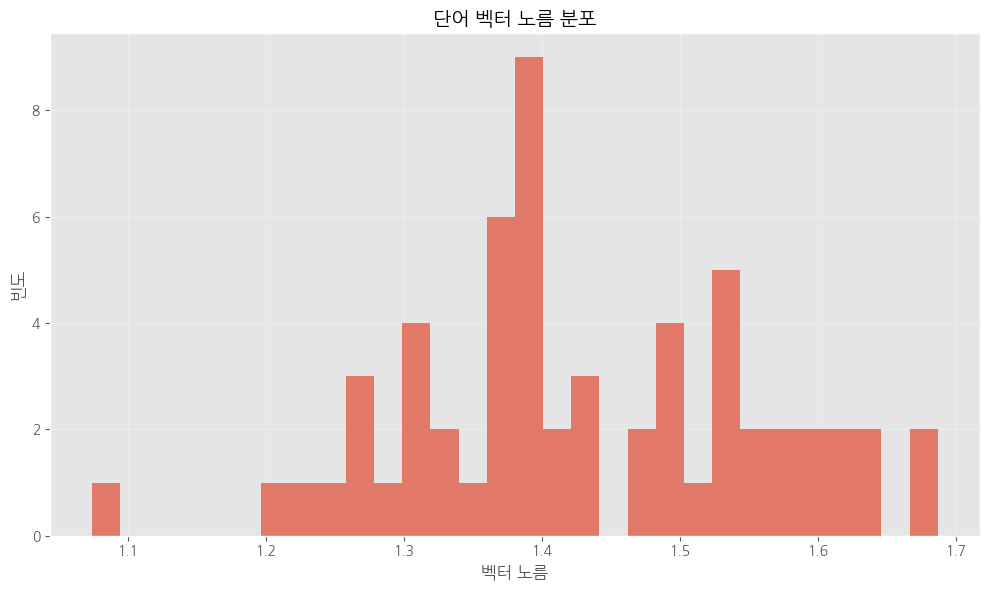

In [ ]:
# 임베딩 기본 통계 출력
print(f"임베딩 행렬 크기: {combined_embeddings.shape}")
print(f"임베딩 평균: {np.mean(combined_embeddings):.6f}")
print(f"임베딩 표준편차: {np.std(combined_embeddings):.6f}")
print(f"임베딩 최소값: {np.min(combined_embeddings):.6f}")
print(f"임베딩 최대값: {np.max(combined_embeddings):.6f}")

# 단어 벡터의 노름(norm) 분포 시각화
norms = np.linalg.norm(combined_embeddings, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(norms, bins=30, alpha=0.7)
plt.title('단어 벡터 노름 분포', fontsize=14)
plt.xlabel('벡터 노름', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def find_similar_words(word, embeddings, word_to_id, id_to_word, top_n=5):
    """특정 단어와 가장 유사한 단어들을 찾는 함수

    Args:
        word: 대상 단어
        embeddings: 단어 임베 딩 행렬
        word_to_id: 단어 -> 인덱스 사전
        id_to_word: 인덱스 -> 단어 사전
        top_n: 유사 단어 개수

    Returns:
        유사 단어 리스트
    """
    if word not in word_to_id:
        print(f"'{word}' 단어는 어휘 사전에 없습니다.")
        return []

    # 단어 인덱스 가져오기
    word_idx = word_to_id[word]

    # 단어 벡터 가져오기
    word_vector = embeddings[word_idx]

    # 코사인 유사도 계산
    similarities = np.dot(embeddings, word_vector) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(word_vector))

    # 유사도 정렬
    similar_indices = np.argsort(similarities)[::-1]
    similar_words = [(id_to_word[idx], similarities[idx]) for idx in similar_indices if idx != word_idx]

    # 상위 N개 단어 반환
    return similar_words[:top_n]

# 유사 단어 탐색 예시
word = 'king'
similar_words = find_similar_words(word, combined_embeddings, word_to_id, id_to_word, top_n=10)

print(f"'{word}'와 가장 유사한 단어들:")
for similar_word, similarity in similar_words:
    print(f"{similar_word}: {similarity:.4f}")

'king' 단어는 어휘 사전에 없습니다.
'king'와 가장 유사한 단어들:


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline

# 한글 폰트 설정 (설정이 필요한 경우)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("한글 폰트 설정에 실패했습니다. 필요한 경우 시스템에 맞는 폰트를 설정해주세요.")

In [ ]:
# GloVe 임베딩 결과 불러오기
try:
    with open('glove_embeddings_results.pkl', 'rb') as f:
        embeddings_results = pickle.load(f)

    center_embeddings = embeddings_results['center_embeddings']
    context_embeddings = embeddings_results['context_embeddings']
    combined_embeddings = embeddings_results['combined_embeddings']
    word_to_id = embeddings_results['word_to_id']
    id_to_word = embeddings_results['id_to_word']
    embedding_dim = embeddings_results['embedding_dim']
    losses = embeddings_results.get('losses', [])

    print("GloVe 임베딩 결과를 성공적으로 불러왔습니다.")
    print(f"임베딩 크기: {combined_embeddings.shape}")
    print(f"임베딩 차원: {embedding_dim}")
    print(f"어휘 사전 크기: {len(word_to_id)} 단어")
except FileNotFoundError:
    print("GloVe 임베딩 결과 파일을 찾을 수 없습니다. 먼저 '4_glove_loss_implementation.ipynb'를 실행해주세요.")

GloVe 임베딩 결과를 성공적으로 불러왔습니다.
임베딩 크기: (59, 50)
임베딩 차원: 50
어휘 사전 크기: 59 단어


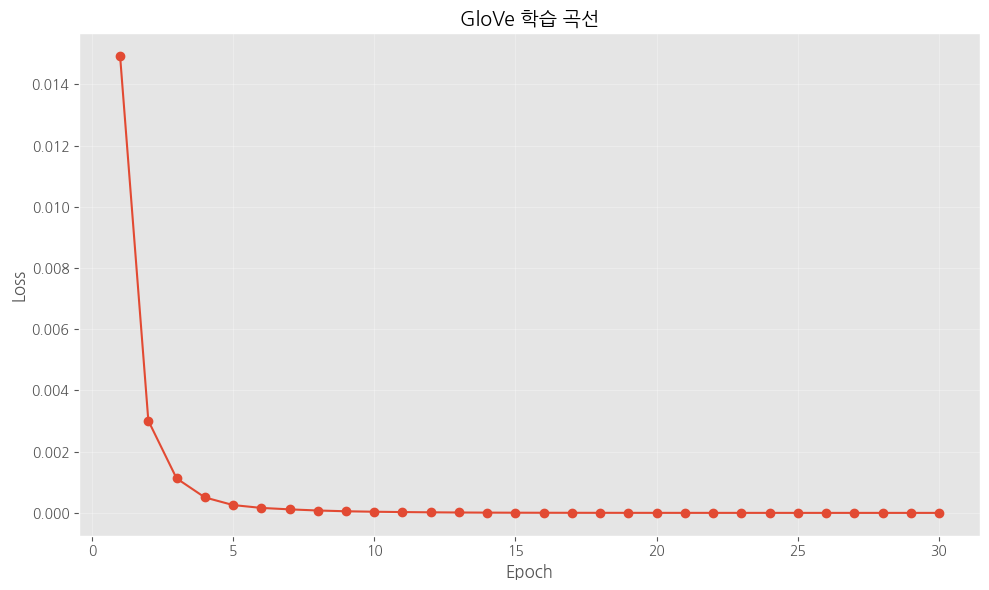

임베딩 통계:
평균 노름: 1.4306
표준편차 노름: 0.1280
최소 노름: 1.0740
최대 노름: 1.6871


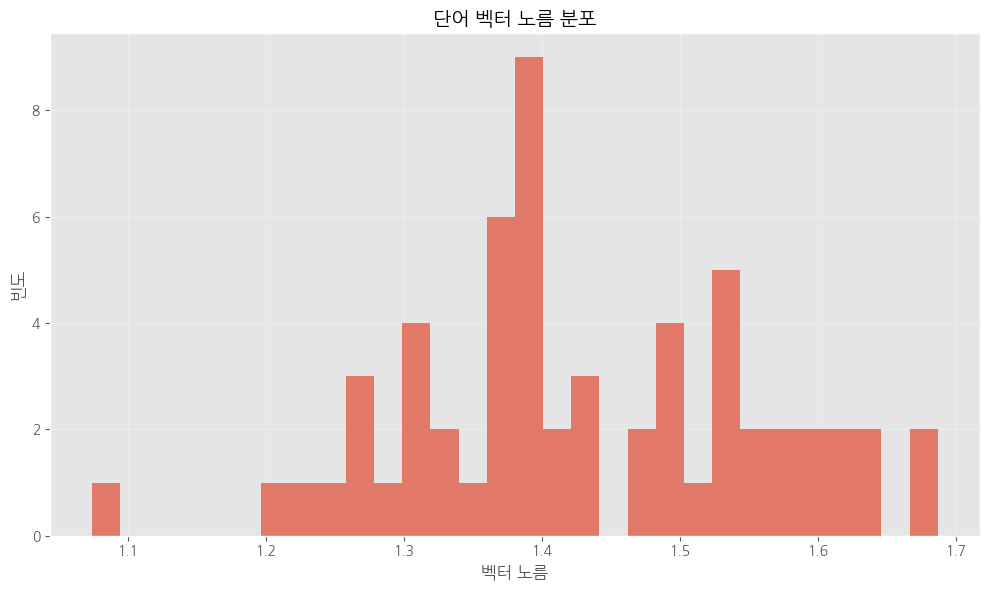

In [ ]:
if losses:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses)+1), losses, marker='o')
    plt.title('GloVe 학습 곡선', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 임베딩 통계량 확인
norms = np.linalg.norm(combined_embeddings, axis=1)

print("임베딩 통계:")
print(f"평균 노름: {np.mean(norms):.4f}")
print(f"표준편차 노름: {np.std(norms):.4f}")
print(f"최소 노름: {np.min(norms):.4f}")
print(f"최대 노름: {np.max(norms):.4f}")

# 노름 분포 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(norms, bins=30, alpha=0.7)
plt.title('단어 벡터 노름 분포', fontsize=14)
plt.xlabel('벡터 노름', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

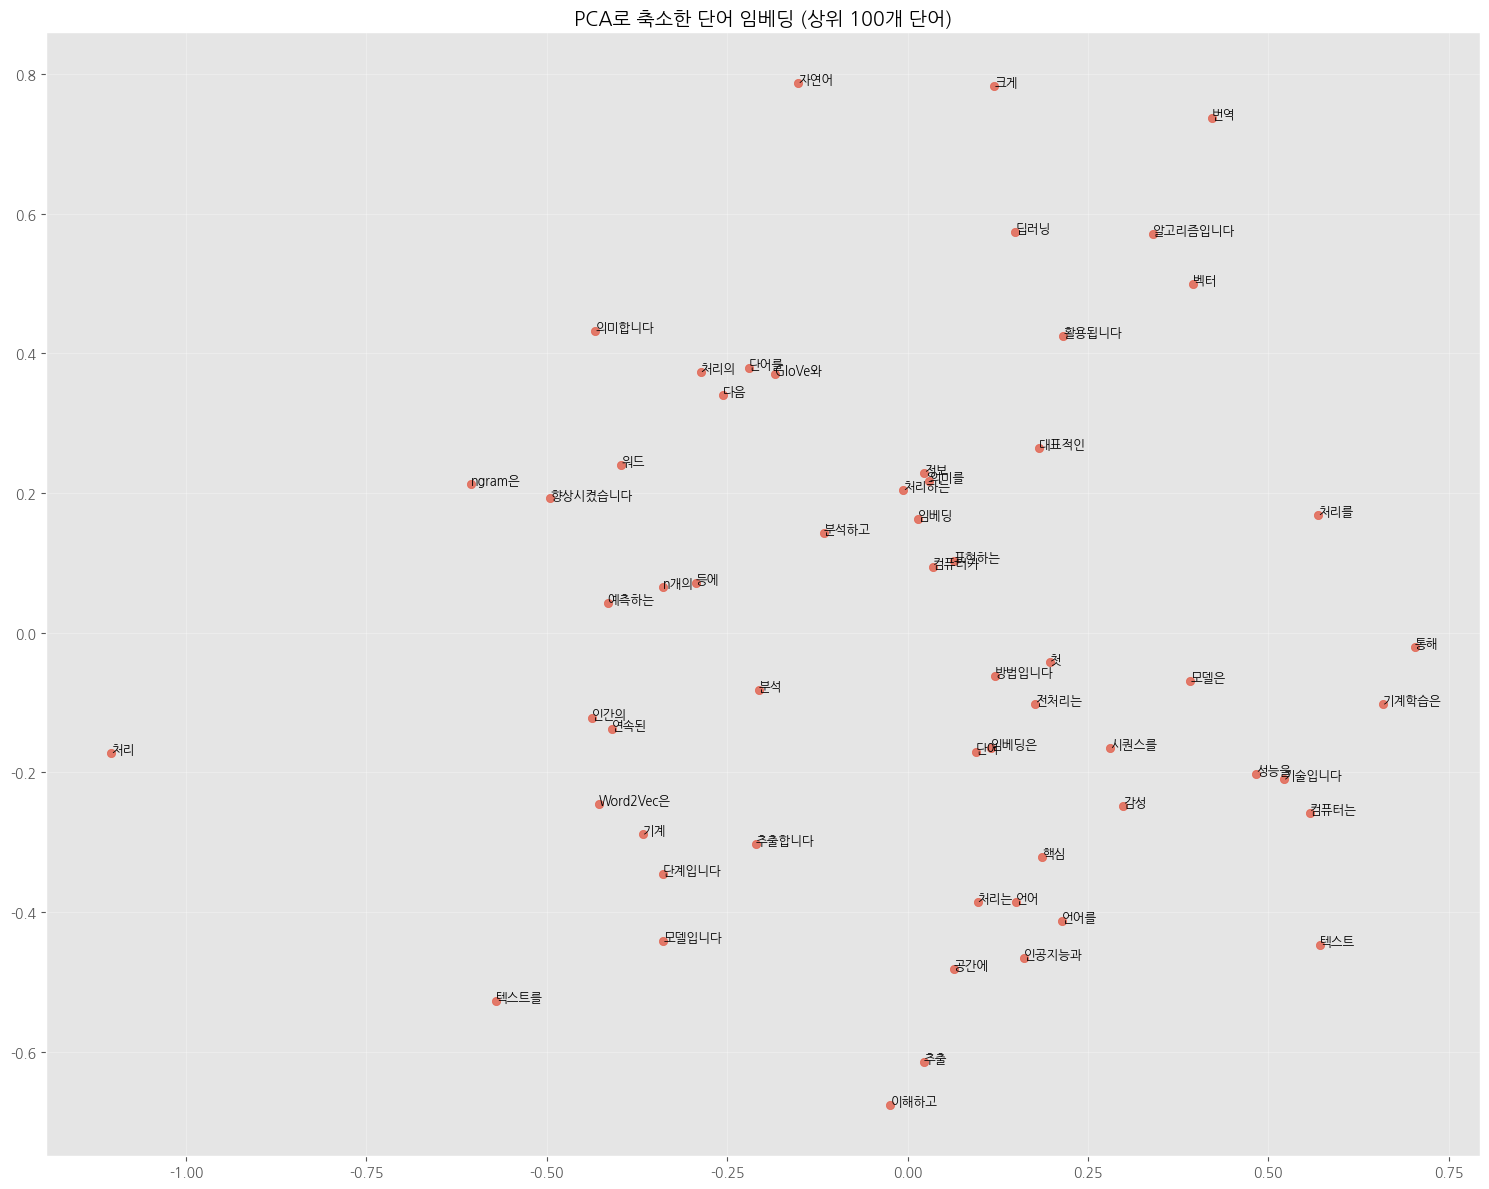

In [ ]:
def reduce_dimensions_pca(embeddings, n_components=2):
    """PCA를 사용하여 임베딩 차원 축소"""
    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

def visualize_embeddings_2d(embeddings_2d, words, title, figsize=(15, 12), max_words=100, annotate=True):
    """2D 임베딩 시각화"""
    plt.figure(figsize=figsize)

    # 표시할 단어 수 제한
    n_words = min(len(words), max_words)

    # 산점도
    plt.scatter(embeddings_2d[:n_words, 0], embeddings_2d[:n_words, 1], alpha=0.7)

    # 단어로 주석 달기
    if annotate:
        for i in range(n_words):
            plt.annotate(words[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 자주 사용되는 단어 선택 (상위 100개)
most_common_words = [word for word, _ in sorted(word_to_id.items(), key=lambda x: word_to_id[x[0]])[:100]]
most_common_ids = [word_to_id[word] for word in most_common_words]

# PCA로 차원 축소
embeddings_pca = reduce_dimensions_pca(combined_embeddings[:100])

# 시각화
visualize_embeddings_2d(embeddings_pca, most_common_words, "PCA로 축소한 단어 임베딩 (상위 100개 단어)")

t-SNE 차원 축소 중... (시간이 다소 걸릴 수 있습니다)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


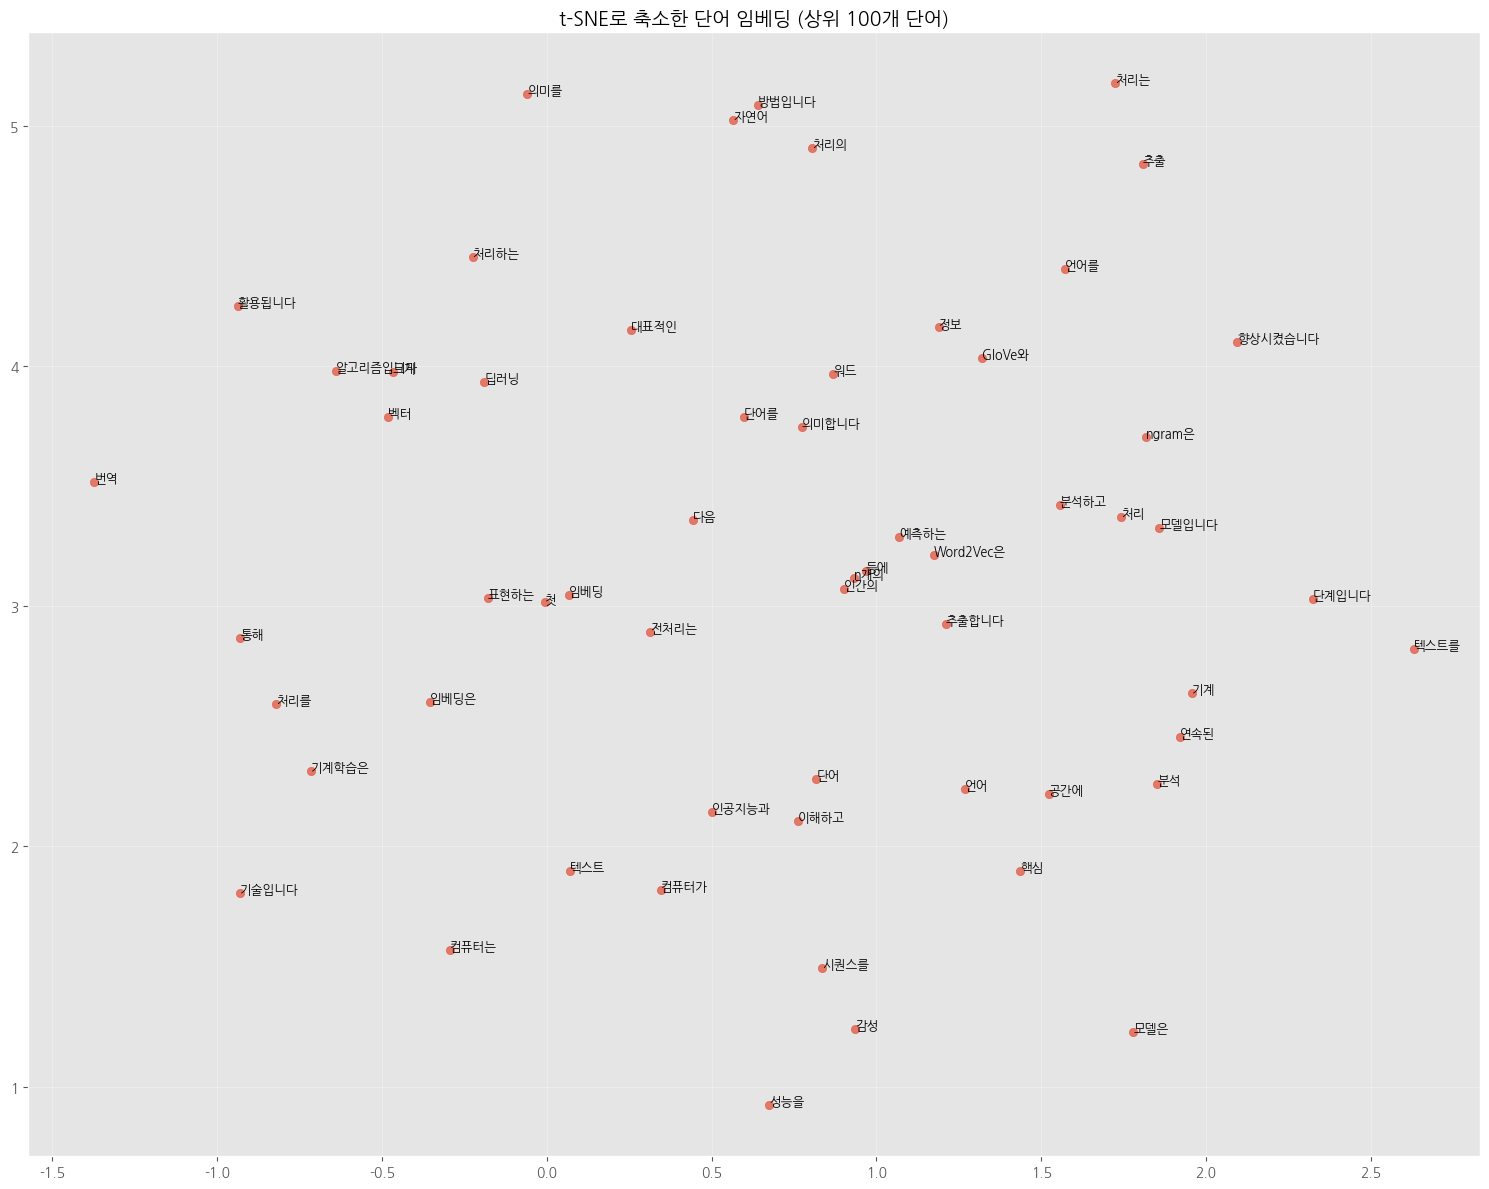

In [ ]:
def reduce_dimensions_tsne(embeddings, n_components=2, perplexity=30, n_iter=1000):
    """t-SNE를 사용하여 임베딩 차원 축소"""
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    return tsne.fit_transform(embeddings)

# t-SNE로 차원 축소 (시간이 오래 걸릴 수 있음)
print("t-SNE 차원 축소 중... (시간이 다소 걸릴 수 있습니다)")
embeddings_tsne = reduce_dimensions_tsne(combined_embeddings[:100])

# 시각화
visualize_embeddings_2d(embeddings_tsne, most_common_words, "t-SNE로 축소한 단어 임베딩 (상위 100개 단어)")

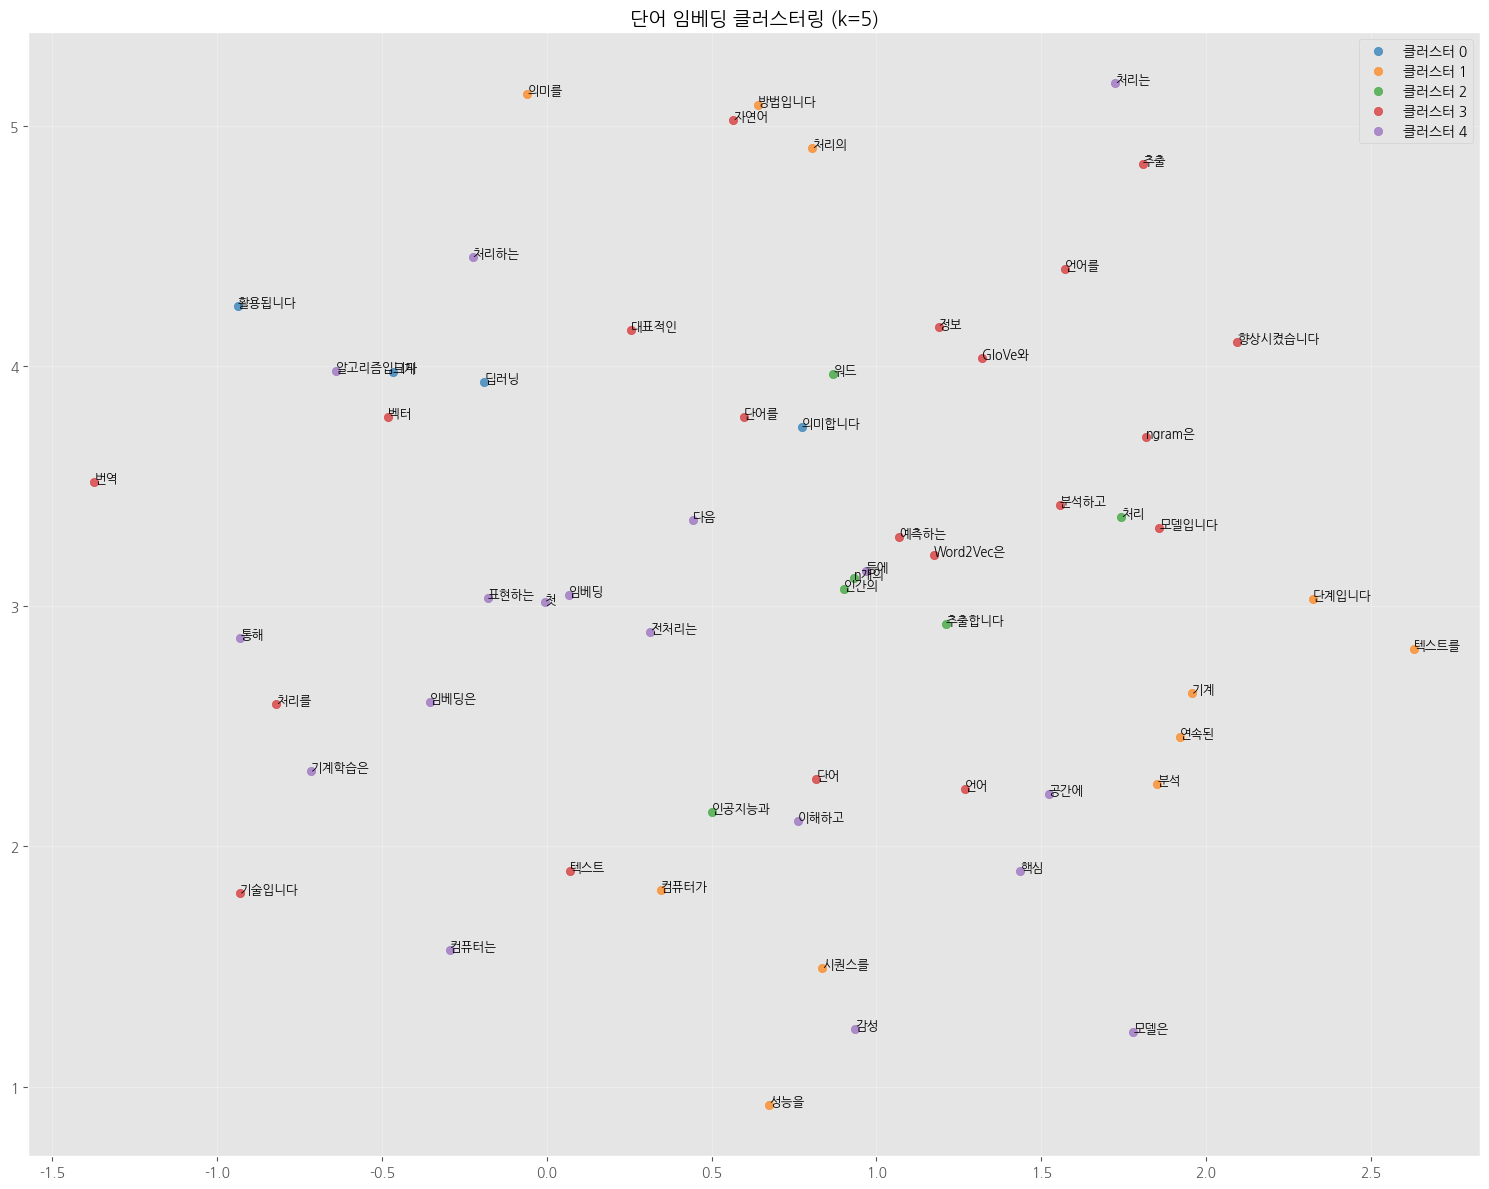


클러스터링 결과 (k=5):
클러스터 0: 딥러닝, 크게, 의미합니다, 활용됩니다
클러스터 1: 처리의, 컴퓨터가, 텍스트를, 의미를, 성능을, 방법입니다, 연속된, 시퀀스를, 기계, 분석...
클러스터 2: 워드, 인간의, 추출합니다, 인공지능과, 처리, n개의
클러스터 3: 자연어, 기술입니다, 단어를, 언어를, 처리를, 분석하고, 향상시켰습니다, 벡터, GloVe와, Word2Vec은...
클러스터 4: 처리는, 모델은, 이해하고, 처리하는, 컴퓨터는, 통해, 기계학습은, 핵심, 임베딩은, 공간에...


In [ ]:
def cluster_words(embeddings, n_clusters=5):
    """단어 임베딩 클러스터링"""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(embeddings)

def visualize_word_clusters(embeddings_2d, words, clusters, title, figsize=(15, 12)):
    """클러스터링 결과 시각화"""
    plt.figure(figsize=figsize)

    # 색상 맵
    colors = plt.cm.tab10.colors

    # 유니크한 클러스터 ID
    unique_clusters = np.unique(clusters)

    for cluster_id in unique_clusters:
        # 해당 클러스터에 속하는 단어 인덱스
        indices = np.where(clusters == cluster_id)[0]

        # 클러스터 데이터 포인트
        cluster_points = embeddings_2d[indices]

        # 산점도
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    color=colors[cluster_id % len(colors)],
                    alpha=0.7, label=f'클러스터 {cluster_id}')

        # 단어로 주석 달기
        for idx in indices:
            plt.annotate(words[idx], (embeddings_2d[idx, 0], embeddings_2d[idx, 1]), fontsize=9)

    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 가장 빈번한 단어 100개 선택 (또는 원하는 다른 단어 셋)
selected_words = most_common_words[:100]
selected_ids = [word_to_id[w] for w in selected_words]
selected_embeddings = combined_embeddings[selected_ids]

# 클러스터링 수행
n_clusters = 5  # 클러스터 수 (필요에 따라 조정)
clusters = cluster_words(selected_embeddings, n_clusters)

# 클러스터링 결과 시각화 (앞서 계산한 t-SNE 결과 활용)
visualize_word_clusters(embeddings_tsne, selected_words, clusters,
                       f"단어 임베딩 클러스터링 (k={n_clusters})")

# 클러스터별 단어 출력
print(f"\n클러스터링 결과 (k={n_clusters}):")
for cluster_id in range(n_clusters):
    indices = np.where(clusters == cluster_id)[0]
    cluster_words = [selected_words[idx] for idx in indices]
    print(f"클러스터 {cluster_id}: {', '.join(cluster_words[:10])}" +
          ("..." if len(cluster_words) > 10 else ""))